In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import ot

import condo

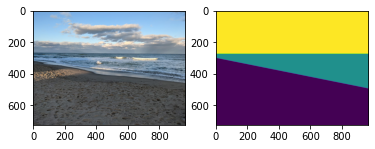

In [2]:
##############################################################################
# Load image data
# ---------------


def im2mat(img):
    """Converts and image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)


def minmax(img):
    return np.clip(img, 0, 1)


# Loading images
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent.parent, 'data')

I1 = plt.imread(os.path.join(data_path, 'ocean_day.jpg')).astype(np.float64) / 256
I2 = plt.imread(os.path.join(data_path, 'ocean_sunset.jpg')).astype(np.float64) / 256
I3 = plt.imread(os.path.join(data_path, 'cape_cod.jpg')).astype(np.float64) / 256

I1seg = I1.copy().astype(str)
I1seg[0:400, :, :] = 'sky'
I1seg[400:, :, :] = 'water'

I2seg = I2.copy().astype(str)
I2seg[0:500, :, :] = 'sky'
I2seg[500:, :, :] = 'water'

I3is, I3js = np.meshgrid(range(I3.shape[0]), range(I3.shape[1]), indexing='ij')
I3segshow = np.where(I3is - 300 < I3js/5, 1, 0)
I3segshow[0:275, :] += 1
I3seg = np.where(I3is - 300 < I3js/5, "water", "sand")
I3seg[0:275, :] = "sky"
fig, axes = plt.subplots(1, 2)
axes[0].imshow(I3)
axes[1].imshow(I3segshow)


Y1 = im2mat(I1seg)[:, [0]]
Y2 = im2mat(I2seg)[:, [0]]
Y3 = im2mat(np.expand_dims(I3seg, 2))

X1 = im2mat(I1)
X2 = im2mat(I2)
X3 = im2mat(I3)

# Feature-Shift Only (Day to Sunset)

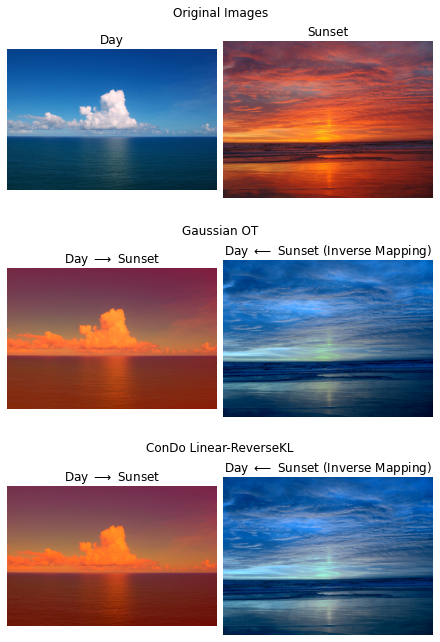

In [3]:
# Estimate mapping and adapt
otda12 = ot.da.LinearTransport()
otda12.fit(Xs=X1, Xt=X2)
xst_otda12 = otda12.transform(Xs=X1)
xts_otda12 = otda12.inverse_transform(Xt=X2)
I1t_otda12 = minmax(mat2im(xst_otda12, I1.shape))
I2t_otda12 = minmax(mat2im(xts_otda12, I2.shape))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder12 = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="affine",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0
    )
cder12.fit(X1, X2, Y1, Y2)
xst_linear12 = cder12.transform(X1)
xts_linear12 = cder12.inverse_transform(X2)
I1t_linear12 = minmax(mat2im(xst_linear12, I1.shape))
I2t_linear12 = minmax(mat2im(xts_linear12, I2.shape))

# Plot transformed images
fig = plt.figure(figsize=(6, 9), constrained_layout=True)

subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Original Images');
axes = subfigs[0].subplots(nrows=1, ncols=2)
axes[0].imshow(I1)
axes[0].axis('off')
axes[0].set_title('Day')
axes[1].imshow(I2)
axes[1].axis('off')
axes[1].set_title('Sunset');

subfigs[1].suptitle('Gaussian OT');
axes = subfigs[1].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_otda12)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Sunset')
axes[1].imshow(I2t_otda12)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Sunset (Inverse Mapping)')

subfigs[2].suptitle('ConDo Linear-ReverseKL');
axes = subfigs[2].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_linear12)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Sunset')
axes[1].imshow(I2t_linear12)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Sunset (Inverse Mapping)');

fig.savefig("figure-DayToSunset.pdf", bbox_inches="tight")

# Confounded Shift (Day to Beach)

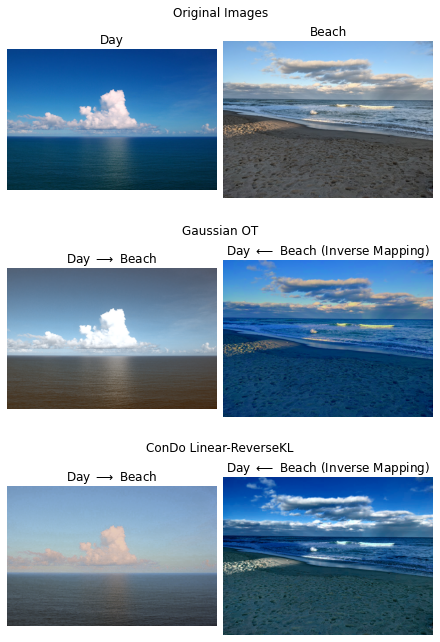

In [4]:
# Estimate mapping and adapt
otda13 = ot.da.LinearTransport()
otda13.fit(Xs=X1, Xt=X3)
xst_otda13 = otda13.transform(Xs=X1)
xts_otda13 = otda13.inverse_transform(Xt=X3)
I1t_otda13 = minmax(mat2im(xst_otda13, I1.shape))
I3t_otda13 = minmax(mat2im(xts_otda13, I3.shape))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder13 = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="affine",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0
    )
cder13.fit(X1, X3, Y1, Y3)
xst_linear13 = cder13.transform(X1)
xts_linear13 = cder13.inverse_transform(X3)
I1t_linear13 = minmax(mat2im(xst_linear13, I1.shape))
I3t_linear13 = minmax(mat2im(xts_linear13, I3.shape))

# Plot transformed images
fig = plt.figure(figsize=(6, 9), constrained_layout=True)

subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Original Images');
axes = subfigs[0].subplots(nrows=1, ncols=2)
axes[0].imshow(I1)
axes[0].axis('off')
axes[0].set_title('Day')
axes[1].imshow(I3)
axes[1].axis('off')
axes[1].set_title('Beach');

subfigs[1].suptitle('Gaussian OT');
axes = subfigs[1].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_otda13)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Beach')
axes[1].imshow(I3t_otda13)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Beach (Inverse Mapping)')

subfigs[2].suptitle('ConDo Linear-ReverseKL');
axes = subfigs[2].subplots(nrows=1, ncols=2)
axes[0].imshow(I1t_linear13)
axes[0].axis('off')
axes[0].set_title('Day $\longrightarrow$ Beach')
axes[1].imshow(I3t_linear13)
axes[1].axis('off')
axes[1].set_title('Day $\longleftarrow$ Beach (Inverse Mapping)');

fig.savefig("figure-DayToBeach.pdf", bbox_inches="tight")

# Confounded Shift (Sunset to Beach)

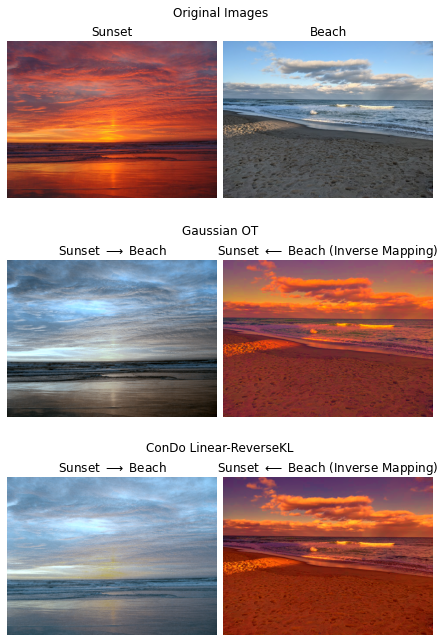

In [6]:
# Estimate mapping and adapt
otda23 = ot.da.LinearTransport()
otda23.fit(Xs=X2, Xt=X3)
xst_otda23 = otda23.transform(Xs=X2)
xts_otda23 = otda23.inverse_transform(Xt=X3)
I2t_otda23 = minmax(mat2im(xst_otda23, I2.shape))
I3t_otda23 = minmax(mat2im(xts_otda23, I3.shape))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder23 = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="affine",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0
    )
cder23.fit(X2, X3, Y2, Y3)
xst_linear23 = cder23.transform(X2)
xts_linear23 = cder23.inverse_transform(X3)
I2t_linear23 = minmax(mat2im(xst_linear23, I2.shape))
I3t_linear23 = minmax(mat2im(xts_linear23, I3.shape))

# Plot transformed images
fig = plt.figure(figsize=(6, 9), constrained_layout=True)

subfigs = fig.subfigures(nrows=3, ncols=1)
subfigs[0].suptitle('Original Images');
axes = subfigs[0].subplots(nrows=1, ncols=2)
axes[0].imshow(I2)
axes[0].axis('off')
axes[0].set_title('Sunset')
axes[1].imshow(I3)
axes[1].axis('off')
axes[1].set_title('Beach');

subfigs[1].suptitle('Gaussian OT');
axes = subfigs[1].subplots(nrows=1, ncols=2)
axes[0].imshow(I2t_otda23)
axes[0].axis('off')
axes[0].set_title('Sunset $\longrightarrow$ Beach')
axes[1].imshow(I3t_otda23)
axes[1].axis('off')
axes[1].set_title('Sunset $\longleftarrow$ Beach (Inverse Mapping)')

subfigs[2].suptitle('ConDo Linear-ReverseKL');
axes = subfigs[2].subplots(nrows=1, ncols=2)
axes[0].imshow(I2t_linear23)
axes[0].axis('off')
axes[0].set_title('Sunset $\longrightarrow$ Beach')
axes[1].imshow(I3t_linear23)
axes[1].axis('off')
axes[1].set_title('Sunset $\longleftarrow$ Beach (Inverse Mapping)');

fig.savefig("figure-SunsetToBeach.pdf", bbox_inches="tight")